In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
from pmlb import fetch_data

X, y = fetch_data('1201_BNG_breastTumor', return_X_y=True)

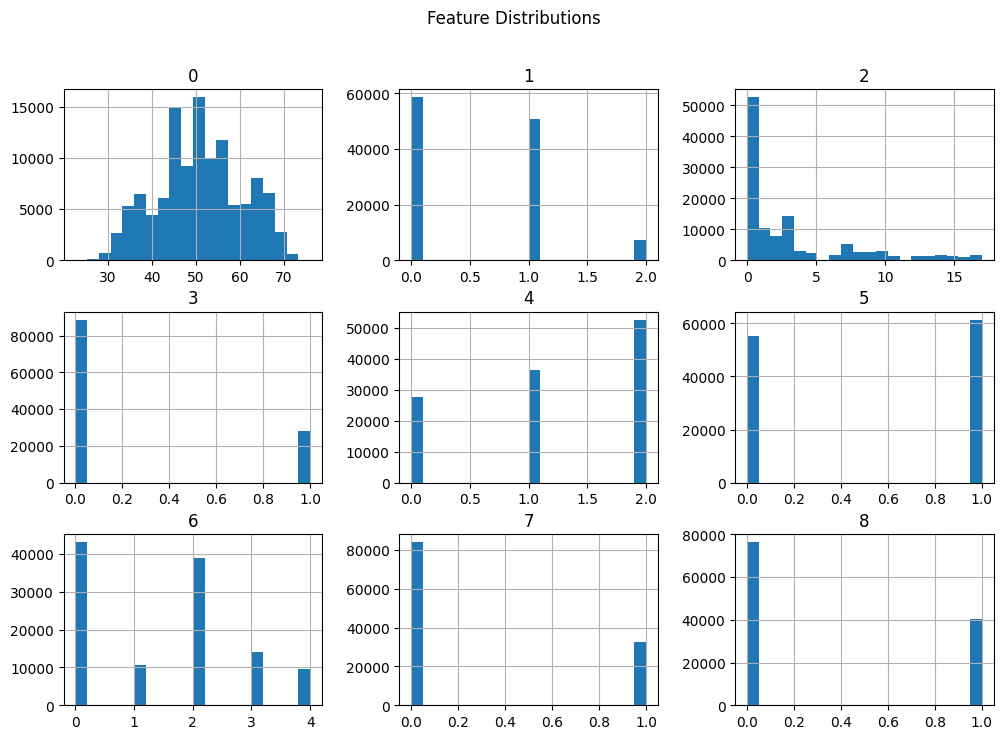

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_df = pd.DataFrame(X)
X_df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

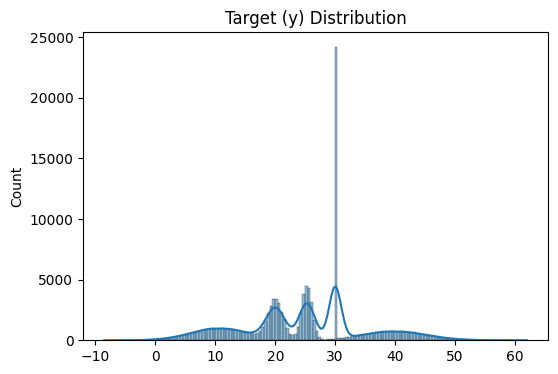

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

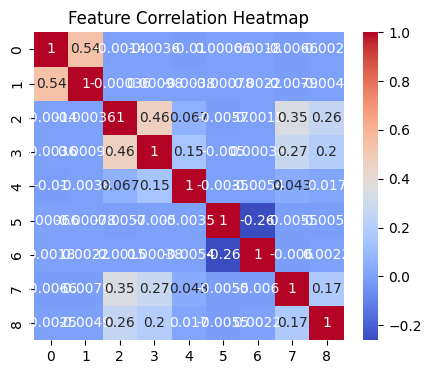

In [7]:
plt.figure(figsize=(5, 4))
corr = X_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.002852                 1.014664             1.364560   
1                  1.001766                 1.019822             1.374285   
2                  1.001926                 0.999613             1.129737   
3                  1.001131                 1.009066             1.068440   
4                  1.007155                 1.020577             1.545277   
mean               1.002966                 1.012748             1.296460   
std                0.002421                 0.008676             0.195188   

      DefaultBART_Rhat_RMSE  
0                  1.672227  
1                  1.951463  
2                  1.615062  
3                  1.361000  
4                  1.347712  
mean               1.589493  
std                0.249594  


In [9]:
rhat_df.to_csv("results/real5_BreastTumor_rhat.csv", index=False)

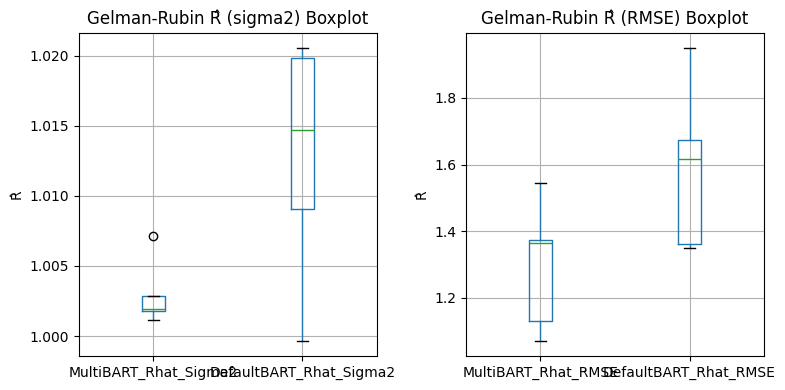

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

test_mse:
      bart_mtmh       bart        btz          rf        xgb
0     86.995604  87.427802  87.289641  109.458282  88.657922
1     87.150692  87.432957  87.319037  109.713743  88.580468
2     87.481414  87.841528  87.548842  110.045747  88.964341
3     87.704551  87.793042  87.834758  110.812855  89.112601
4     88.513185  88.712077  88.603959  110.663165  90.279935
5     87.534936  87.807228  87.901896  110.808684  89.136747
6     87.602005  87.846096  87.892939  111.041204  89.535712
7     87.869379  88.024979  88.076816  110.612982  89.441630
8     88.170118  88.359134  88.499003  111.407565  89.900800
9     87.172930  87.565333  87.466861  110.821577  88.721746
mean  87.619481  87.881018  87.843375  110.538580  89.233190
std    0.472170   0.403011   0.456904    0.609861   0.556879



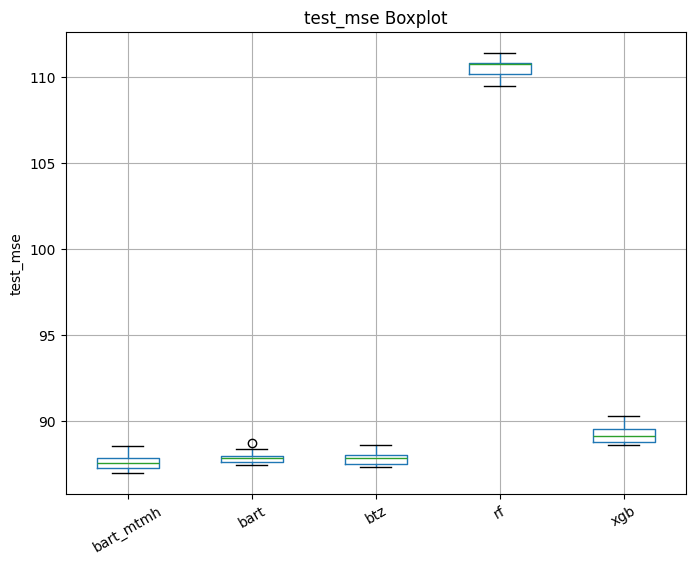

train_mse:
      bart_mtmh       bart        btz         rf        xgb
0     87.017276  87.686708  87.572981  15.534903  81.455847
1     87.065233  87.718501  87.598075  15.447441  81.404006
2     86.902345  87.534355  87.409541  15.395193  81.251570
3     86.921649  87.356116  87.548165  15.370045  81.250468
4     86.616801  87.212902  87.244632  15.341230  81.338999
5     86.908512  87.515378  87.536499  15.404729  81.252545
6     86.872712  87.460060  87.451229  15.432257  81.214583
7     86.869465  87.286973  87.415487  15.364956  81.153972
8     86.677463  87.302707  87.219002  15.369475  81.192552
9     87.037058  87.610328  87.615570  15.472823  81.257820
mean  86.888851  87.468403  87.461118  15.413305  81.277236
std    0.145505   0.174876   0.140914   0.059235   0.094540



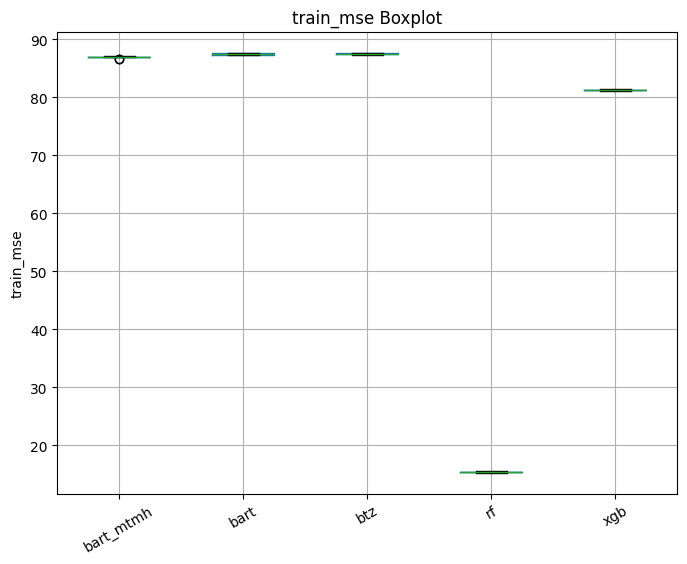

pi_length:
      bart_mtmh       bart        btz
0     36.570175  36.633152  36.715908
1     36.561284  36.632730  36.710690
2     36.515304  36.620472  36.685307
3     36.519568  36.564964  36.673599
4     36.478180  36.513287  36.622650
5     36.533298  36.591726  36.713333
6     36.525842  36.605360  36.663113
7     36.509947  36.542108  36.674175
8     36.486773  36.547917  36.661663
9     36.553196  36.603006  36.707047
mean  36.525357  36.585472  36.682747
std    0.030229   0.041360   0.029836



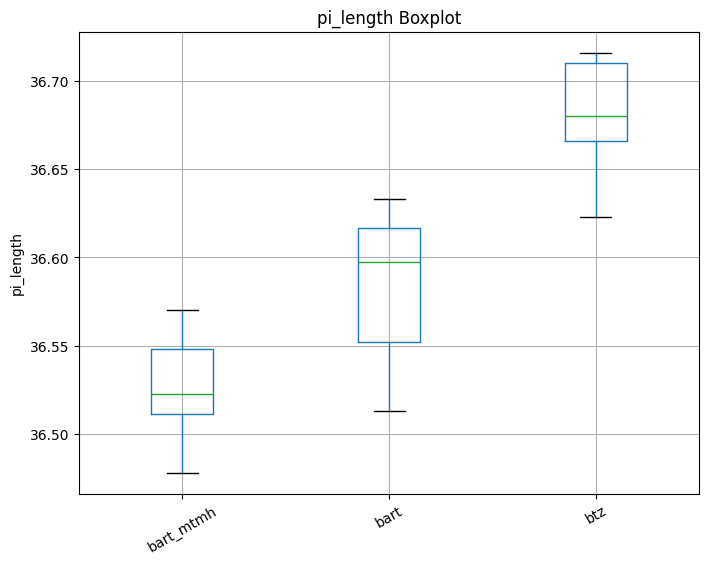

coverage:
      bart_mtmh      bart       btz
0      0.936968  0.937311  0.937689
1      0.936591  0.937243  0.938615
2      0.936694  0.936763  0.937723
3      0.936317  0.936900  0.937997
4      0.935219  0.935631  0.936283
5      0.936866  0.938272  0.938546
6      0.935185  0.935837  0.936351
7      0.937277  0.937586  0.938957
8      0.934945  0.936591  0.936077
9      0.935048  0.935974  0.937174
mean   0.936111  0.936811  0.937541
std    0.000908  0.000835  0.001039



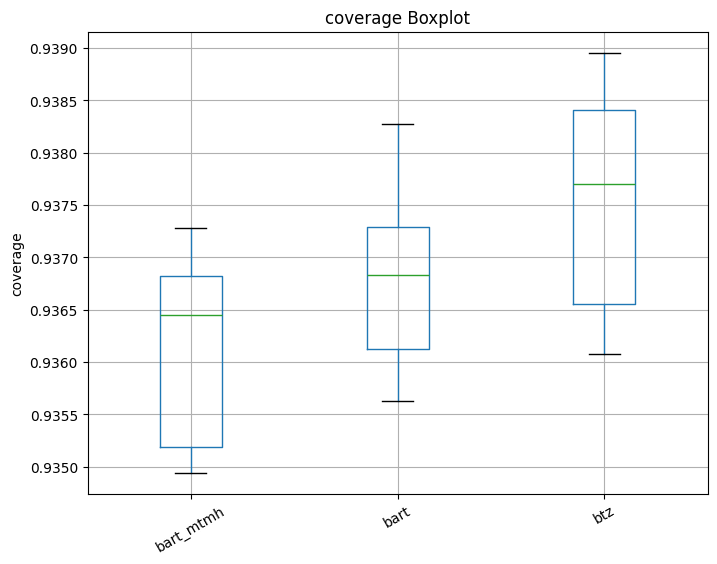

train_time:
        bart_mtmh        bart         btz         rf       xgb
0     2977.888018  349.699071  175.284484  31.295980  0.866618
1     3033.406565  345.935534  167.346368  23.010331  0.895029
2     2968.709718  329.535794  172.416450  37.409992  0.820485
3     2973.852484  332.260338  178.638318  31.914379  0.619055
4     2969.851899  333.419995  174.016433  34.033488  0.662295
5     3188.789691  384.179172  155.598777  33.917503  0.376234
6     3227.926132  410.400587  160.054564  24.354873  0.383756
7     3108.203704  372.222365  148.894781  25.830132  0.228785
8     3221.494959  410.033818  157.203367  23.619505  0.337535
9     3082.056686  339.215302  145.327205  29.290356  0.200552
mean  3075.217986  360.690198  163.478075  29.467654  0.539034
std    106.818847   31.469266   11.692551   5.037188  0.266019



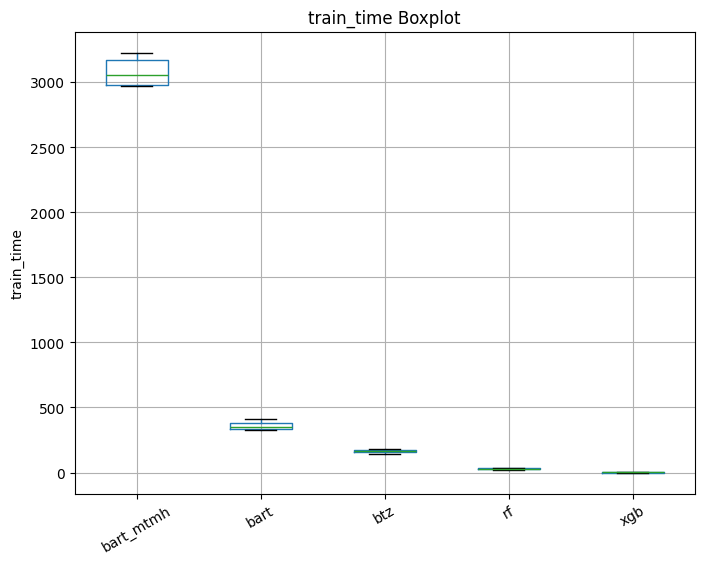

In [11]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [12]:
for k, v in mse_results.items():
    csv_name = f"results/real5_BreastTumor_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [ ]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real5_BreastTumor_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real5_BreastTumor_tries.csv", index=False)

In [ ]:
print(df)